In [24]:
# import necessary libraries
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split


SEED=42

In [25]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

In [26]:
# cargar los datos
df_original = pd.read_csv('data/tipo1_entrenamiento_estudiantes.csv')

# Entendimiento

In [27]:
df_original.shape

(7875, 2)

In [28]:
df_original.sample(5)

,Review,Class
1929,"Te sorprendes con el embrujo de el Centro de Cartagena. Lo máximo caminar por las plazas, ver el atardecer, sentir la brisa.",5
6840,"Si no has visitado este pequeño restaurante en la Habana, tienes que ponerlo en tu debe tener lista! Fabulosa comida, gran servicio y la mejor Cubanito! Buenos precios, también! ¡Muy recomendable!",5
6773,"La descripción del hotel no es ni por asomo parecido a la verdad Por el contrario es un hotel viejo, mal cuidado y por supuesto no se acerca en nada a la idea que nos habíamos hecho del mismo. Las primera habitación que nos dieron era vieja descuidada y sucia, para colmo me fue imposible dormir del espantoso ruido de música de discoteca que atronaba durante gran parte de la noche. El mobiliario era viejo y sucio, así como el baño. El aire acondicionado era imposible de regular y si se quitaba hacía bastante calor. Eso sumado a que la cama tenía un edredón nórdico que ya quisieran tener en e Finlandia en las meses de invierno. La segunda habitación un poco mejor pero por supuesto no para un hotel de 5 ***** La comida fue mala y con poca variedad No recomendable en absoluto",1
3443,"Local en el centro de la Habana, buen lugar para escuchar música típicamente Cubana donde esta actividad esta muy potenciada por un grupo muy profesional.\ncomida como en todos los lugares de la zona, salsas sin sabor, frituras (muy poco recomendables) pescado ......, deberían mejorar...Más",2
3523,Fuimos a descuidadas Joes después de la cena. noche de diversión. Tenía una banda para celebrar cumpleaños de camarera. Añadido a la cultura y la diversión. Buen servicio y buen ambiente. Viaje Merece la pena.,4


In [29]:
df_original.isnull().sum()

Review    0
Class     0
dtype: int64

No hay registros nulos, los datos son completos.

<Axes: xlabel='Class'>

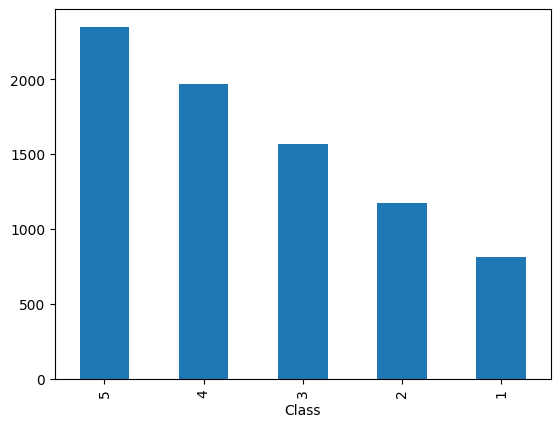

In [30]:
# distribución de variable objetivo
df_original['Class'].value_counts().plot(kind='bar')

Todos los valores de la columna 'Class' son válidos.

In [31]:
df_original.duplicated().sum()

71

Hay 71 registro duplicados, estos se deben eliminar del dataset.

In [32]:
duplicated_rows = df_original[df_original.duplicated()]
duplicated_rows


,Review,Class
518,"La ubicación es muy buena, al igual que la vista, la playa contrario a lo que esperaba resultó que estaba bastante limpia.\nSe percibe el sabor y la frescura en los insumos de los alimentos , lo cual es parte de la experiencia que ofrece...el lugar ya que tienen sus propias granjas productoras. La carta es limitada ( lo cual en mi caso prefiero, ya que se nota el esmero en cada uno de los platos que preparan), los precios están por arriba del promedio de otros restaurantes cercanos pero no llegan a ser exagerados, desconozco si eso se debió a que solo se tenía un salón disponible, ya que en la fecha que lo visité, el resto del restaurante se encontraba en remodelación (es la único razón por lo cual no otorgo la evaluación más alta), mi sugerencia sería que siguieran manteniendo los precios ya que los hace muy competitivos … sin duda regresaría, es un lugar que debes visitar en Veracruz sobre todo si eres fanático del buen comer…Más",4
1112,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
1605,"Cierran a las 3 pm, cobraron $85 adultos y niños (por lo menos los de 2 años) y adulto mayor gratis. A la entrada hay guías. Se juntan grupos de mínimo 10 personas y te cobran $70 por persona o $700 a quien se los pague. Excelente explicación y atención de parte de ellos. Poca claridad de información en redes, y el número telefónico no sirve. Llegamos fácilmente con waze. Lleven buen bloqueador, sombrero y de preferencia tenis.",3
1843,"Acudimos un sábado 2 de julio a las 11:15 de la mañana. Estuvimos esperando más de media hora nosotros dos y otro grupo de cuatro personas fuera, porque la camarera estaba dentro. Nos vio como estábamos esperando y no fue capaz de salir a atendernos...o dar alguna explicación si el bar estaba abierto o cerrado.\n\nNos tuvimos que marcharMás",1
1851,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
...,...,...
7520,"Un lugar muy limpio ordenado hermoso con áreas amplias que vale la pena disfrutar en familia un momento, primera vez que lo visito pero vale la pena acudir.",3
7601,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
7756,Deben de actualizar los horarios en las diferentes páginas ya que como yo o cualquiera de los visitantes que vamos podemos llegar y encontrar cerrado y luego la página para buscar información no funciona.,3
7794,"Wow Había escuchado muchas recomendaciones de este lugar, pero nunca había ido, hace unos fui y me precio muy interesante toda las historias que hay en este museo.",5


# Procesamiento y Preparación

In [33]:
# eliminar las filas duplicadas
df_prep = df_original.drop_duplicates()

In [34]:
df_prep.shape

(7804, 2)

In [35]:
# TODO: balancear las clases (variable objetivo)

## Divisón en entrenamiento y prueba 

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_prep["Review"], df_prep["Class"], test_size = 0.2, stratify = df_prep["Class"], random_state = SEED)

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6243,), (1561,), (6243,), (1561,))

## Tokenización / Vectorización

"Feature engineering"

* Bag of Words / Count Tokenizer
* Tf-IDF

In [44]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [46]:
# Descargar los datos necesarios
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andresarevalo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andresarevalo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [47]:
stop_words = set(stopwords.words('spanish'))

In [48]:
def tokenize_text(text):
    # eliminar caracteres numericos
    text = re.sub(r'\d+', '', text)    

    # eliminar puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
     
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons TODO: not all emojis included here
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               "]+", flags=re.UNICODE)
    sans_emoji = emoji_pattern.sub(r'', text)
    return word_tokenize(sans_emoji)

In [49]:
bow_vectorizer = CountVectorizer(stop_words=list(stop_words), lowercase=True, tokenizer=tokenize_text)
tfidf_vectorizer = TfidfVectorizer( stop_words=list(stop_words), lowercase=True, tokenizer=tokenize_text)

In [50]:
X_train_bow = bow_vectorizer.fit_transform(X_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [51]:
len(bow_vectorizer.vocabulary_)

24863

In [52]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [53]:
len(tfidf_vectorizer.vocabulary_)

24863

In [54]:
df_bow_sklearn = pd.DataFrame(X_train_bow.toarray(),columns=bow_vectorizer.get_feature_names_out())
df_bow_sklearn

,aa,aaaaa,aaaahed,aasequible,ab,abad,abajo,abajolo,abajomás,abalanzan,...,❤,❤️,➕,️,🇨🇴,🇺🇾,🛌🛋,🤤,🤪,🤪🤣
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Entrenamiento y evaluación de modelos

## [nombre algoritmo]

Desarrollado por:

[descripción]

### Conclusiones

## [nombre algoritmo]

Desarrollado por:

[descripción]

### Conclusiones

## [nombre algoritmo]

Desarrollado por:

[descripción]

### Conclusiones

## Selección de final